In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import pickle
import glob
from collections import defaultdict, Counter

# plt 세팅
plt.rc('font', family='Malgun Gothic')  # 한글 폰트
plt.rc('axes', unicode_minus=False)  # 마이너스 기호

In [2]:
def load_all_region_data(dataset_dir):
    all_files = glob.glob(os.path.join(dataset_dir, '*.csv'))
    dfs = []
    for file in all_files:
        region_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]  # 서울_202412.csv -> 서울
        df = pd.read_csv(file, encoding='utf-8')
        selected_columns = ['상가업소번호', '상호명', '상권업종소분류명']
        df_region = df[selected_columns].copy()
        df_region['지역'] = region_name
        df_clean = df_region.dropna(subset=['상호명', '상권업종소분류명'])
        dfs.append(df_clean)
        print(f"{region_name} 데이터 크기: {df_clean.shape}")
    region_all_df = pd.concat(dfs, ignore_index=True)
    print(f"전체 통합 데이터 크기: {region_all_df.shape}")

    return region_all_df

In [3]:
region_all_df = load_all_region_data('./dataset')

강원 데이터 크기: (111392, 4)


C:\Users\hojin\AppData\Local\Temp\ipykernel_31112\1633060659.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='utf-8')


경기 데이터 크기: (672885, 4)
경남 데이터 크기: (176942, 4)
경북 데이터 크기: (147012, 4)
광주 데이터 크기: (78148, 4)
대구 데이터 크기: (119621, 4)
대전 데이터 크기: (80589, 4)
부산 데이터 크기: (161439, 4)
서울 데이터 크기: (553535, 4)
세종 데이터 크기: (15298, 4)
울산 데이터 크기: (55885, 4)
인천 데이터 크기: (138166, 4)
전남 데이터 크기: (102544, 4)


C:\Users\hojin\AppData\Local\Temp\ipykernel_31112\1633060659.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='utf-8')


전북 데이터 크기: (99935, 4)
제주 데이터 크기: (59745, 4)
충남 데이터 크기: (125116, 4)
충북 데이터 크기: (94587, 4)
전체 통합 데이터 크기: (2792839, 4)


In [4]:
print(region_all_df['지역'].value_counts())

지역
경기    672885
서울    553535
경남    176942
부산    161439
경북    147012
인천    138166
충남    125116
대구    119621
강원    111392
전남    102544
전북     99935
충북     94587
대전     80589
광주     78148
제주     59745
울산     55885
세종     15298
Name: count, dtype: int64


In [5]:
# 결측치 확인
print("결측치 개수:")
missing_values = region_all_df.isnull().sum()
print(missing_values)

결측치 개수:
상가업소번호      0
상호명         0
상권업종소분류명    0
지역          0
dtype: int64


In [6]:
region_all_df

,상가업소번호,상호명,상권업종소분류명,지역
0,MA010120220800001545,클러버,요리 주점,강원
1,MA010120220800001666,최병영법률사무소,변호사,강원
2,MA010120220800002200,깡통,남성 의류 소매업,강원
3,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원
4,MA010120220800004187,우리약초,채소/과일 소매업,강원
...,...,...,...,...
2792834,MA0106202201A2188326,고캠프,운동용품 소매업,충북
2792835,MA0106202201A0857023,사진,사진촬영업,충북
2792836,MA0106202201A2048521,올리비아로렌,기타 의류 소매업,충북
2792837,MA0106202201A0896107,박대장김밥,김밥/만두/분식,충북


In [7]:
# 상호명 정규화
def normalize_store_name(name):
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]', ' ', name) # 한글, 영문, 숫자만 남기고 나머지는 공백으로 변환
    # 변환 후 연속된 공백 제거
    cleaned = re.sub('  ', ' ', cleaned).strip()
    cleaned = re.sub('   ', ' ', cleaned).strip()
    cleaned = re.sub('    ', ' ', cleaned).strip()
    return cleaned
    # return cleaned.lower()  # 소문자? 대문자? 원본 그대로?
    # return cleaned.upper()

In [8]:
region_all_df['상호명_Regulated'] = region_all_df['상호명'].apply(normalize_store_name)
region_all_df

,상가업소번호,상호명,상권업종소분류명,지역,상호명_Regulated
0,MA010120220800001545,클러버,요리 주점,강원,클러버
1,MA010120220800001666,최병영법률사무소,변호사,강원,최병영법률사무소
2,MA010120220800002200,깡통,남성 의류 소매업,강원,깡통
3,MA010120220800002703,금수강산컨설팅,부동산 중개/대리업,강원,금수강산컨설팅
4,MA010120220800004187,우리약초,채소/과일 소매업,강원,우리약초
...,...,...,...,...,...
2792834,MA0106202201A2188326,고캠프,운동용품 소매업,충북,고캠프
2792835,MA0106202201A0857023,사진,사진촬영업,충북,사진
2792836,MA0106202201A2048521,올리비아로렌,기타 의류 소매업,충북,올리비아로렌
2792837,MA0106202201A0896107,박대장김밥,김밥/만두/분식,충북,박대장김밥


In [9]:
# 중복 상호명 확인
df_len = len(region_all_df.index)
unique_name_counts = region_all_df['상호명_Regulated'].value_counts()
duplicated_names = unique_name_counts[unique_name_counts > 1]

print(f"중복된 상호명 수: {len(duplicated_names)} / {df_len}")
print("고유 상호명 수 :", len(unique_name_counts))
print(f"전체 상호명 중 중복 비율: {(df_len - len(unique_name_counts)) / df_len * 100:.2f}%")

print("\n가장 많이 중복된 상호명")
print(duplicated_names.head(20))

중복된 상호명 수: 264926 / 2792839
고유 상호명 수 : 1818487
전체 상호명 중 중복 비율: 34.89%

가장 많이 중복된 상호명
상호명_Regulated
스타벅스          1907
컴퓨터수리         1736
입시 교과학원       1096
입주청소           976
김밥천국           880
업소명없음          778
투다리            680
슈퍼마켓           652
경영 컨설팅업        634
아모레카운셀러        569
아지트            535
교촌치킨           509
맘스터치           489
파리바게뜨          487
다온             477
태후사랑           461
처갓집양념치킨        460
현대공인중개사사무소     459
삼성공인중개사사무소     452
네네치킨           435
Name: count, dtype: int64


In [10]:
# 중복 상호명의 업종 분포 확인
for name in duplicated_names.index[:5]:
    categories = region_all_df[region_all_df['상호명_Regulated'] == name]['상권업종소분류명'].value_counts()
    print(f"\n'{name}' 업종 분포:")
    print(categories)


'스타벅스' 업종 분포:
상권업종소분류명
카페             1904
경영 컨설팅업           1
주방/가정용품 소매업       1
PC방               1
Name: count, dtype: int64

'컴퓨터수리' 업종 분포:
상권업종소분류명
컴퓨터/노트북/프린터 수리업       1636
가전제품 수리업                42
컴퓨터/소프트웨어 소매업           27
그 외 기타 개인/가정용품 수리업      12
핸드폰/통신장비 수리업            10
핸드폰 소매업                  3
사업/무형 재산권 중개업            2
의류/이불 수선업                2
가죽/가방/신발 수선업             1
광고 대행업                   1
Name: count, dtype: int64

'입시 교과학원' 업종 분포:
상권업종소분류명
입시·교과학원          1091
그 외 기타 교육기관         2
음악학원                1
전문자격/고시학원           1
기타 기술/직업 훈련학원       1
Name: count, dtype: int64

'입주청소' 업종 분포:
상권업종소분류명
건축물 일반 청소업               945
사업시설 유지·관리 서비스업           19
산업설비; 운송장비 및 공공장소 청소업      8
소독; 구충 및 방제 서비스업           2
그 외 기타 개인/가정용품 수리업         1
광고 대행업                     1
Name: count, dtype: int64

'김밥천국' 업종 분포:
상권업종소분류명
김밥/만두/분식    880
Name: count, dtype: int64


In [11]:
def process_duplicate_stores(df, store_col='상호명_Regulated', category_col='상권업종소분류명', verbose=True):
    # 상호명 중복 처리 함수 - 상호명이 중복된 경우 가장 빈도가 높은 업종의 첫번째 컬럼만 남김
    start_time = time.time()
    
    if verbose:
        print(f"원본 데이터: {len(df):,}개 행")
    
    # 고유 상호명을 구해 중복/비중복 여부 구분
    unique_name_counts = df[store_col].value_counts()
    lv_nodup_names = unique_name_counts[unique_name_counts == 1]
    lv_dup_names = unique_name_counts[unique_name_counts > 1]
    
    if verbose:
        print(f"총 고유 상호명 수: {len(unique_name_counts):,}")
        print(f"중복 없는 상호명 수: {len(lv_nodup_names):,}")
        print(f"중복 있는 상호명 수: {len(lv_dup_names):,}")
    
    # 비중복 상호명을 가진 행 리스트에 저장
    selected_rows = df[df[store_col].isin(lv_nodup_names.index)]
    
    if verbose:
        print(f"중복 없는 상호명 처리 완료: {len(selected_rows):,}개 행")
    
    # 중복 상호명 처리
    lv_dup_df = df[df[store_col].isin(lv_dup_names.index)]
    lv_dup_df = lv_dup_df.reset_index(drop=True) #!!인덱스 중복으로 여러 컬럼이 선택되는 문제 해결
    
    if verbose:
        print(f"중복 있는 상호명 데이터: {len(lv_dup_df):,}개 행")
    
    # 업종 빈도 계산
    if verbose:
        print("업종 빈도 계산 시작")
        
    # dict를 활용하여 각 상호명별 업종 빈도 계산
    name_category_counters = defaultdict(Counter)
    for _, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        name_category_counters[name][category] += 1
    
    if verbose:
        print(f"업종 빈도 계산 완료: {len(name_category_counters):,}개 상호명")
    
    # 각 상호명별 최빈 업종 저장
    name_top_category = {}  # 각 상호명의 최빈 업종을 저장
    name_first_index = {}   # 각 상호명+최빈업종의 첫 인덱스를 저장
    
    # 각 상호명의 최빈 업종 찾기
    for name, category_counter in name_category_counters.items():
        if len(category_counter) > 0:
            most_common = category_counter.most_common(1)[0]
            top_category = most_common[0]  # 가장 빈도가 높은 업종
            name_top_category[name] = top_category
    
    # 최빈 업종의 첫 번째 인덱스 찾기
    if verbose:
        print("각 상호명별 최빈 업종 탐색")
        
    for idx, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        # 상호명에 대한 최빈 업종과 일치하는 경우의 인덱스 저장
        if name in name_top_category and category == name_top_category[name] and name not in name_first_index:
            name_first_index[name] = idx
    
    # 인덱스 value를 모아 리스트로
    selected_indices = list(name_first_index.values())
    
    if verbose:
        print(f"선택된 중복 상호명 인덱스 수: {len(selected_indices):,}")
    
    # 인덱스를 기준으로 데이터프레임 생성
    selected_rows_dup = lv_dup_df.loc[selected_indices]
    
    if verbose:
        print(f"중복 있는 상호명 처리 완료: {len(selected_rows_dup):,}개 행 선택됨")
    
    # 중복/비중복 df concat
    lv_final_df = pd.DataFrame(columns=df.columns)
    lv_final_df = pd.concat([lv_final_df, selected_rows, selected_rows_dup], ignore_index=True)
    
    if verbose:
        print(f"최종 데이터 크기: {len(lv_final_df):,}개 행")
        print(f"제거된 중복 데이터: {len(df) - len(lv_final_df):,}개 행")
        print(f"총 소요 시간: {time.time() - start_time:.2f}초")
    
    return lv_final_df

In [12]:
# 중복 상호명 처리
processed_df = process_duplicate_stores(region_all_df, verbose=True)

원본 데이터: 2,792,839개 행
총 고유 상호명 수: 1,818,487
중복 없는 상호명 수: 1,553,561
중복 있는 상호명 수: 264,926
중복 없는 상호명 처리 완료: 1,553,561개 행
중복 있는 상호명 데이터: 1,239,278개 행
업종 빈도 계산 시작
업종 빈도 계산 완료: 264,926개 상호명
각 상호명별 최빈 업종 탐색
선택된 중복 상호명 인덱스 수: 264,926
중복 있는 상호명 처리 완료: 264,926개 행 선택됨
최종 데이터 크기: 1,818,487개 행
제거된 중복 데이터: 974,352개 행
총 소요 시간: 63.90초


In [13]:
unique_name_counts = processed_df['상호명_Regulated'].value_counts()
lv_nodup_names = unique_name_counts[unique_name_counts == 1]
lv_dup_names = unique_name_counts[unique_name_counts > 1]

In [14]:
len(lv_nodup_names)

1818487

# 여기서부터 다시 작성

In [15]:
# 상호명 중복제거 확인
def check_processing_results(original_df, processed_df, sample_names):
    for name in sample_names:
        print(f"\n'{name}' 처리 결과:")
        # 원본 데이터에서 해당 상호명 검색
        original_records = original_df[original_df['상호명_Regulated'] == name]
        print(f"원본 레코드 수: {len(original_records)}")
        # 처리된 데이터에서 해당 상호명 검색
        processed_records = processed_df[processed_df['상호명_Regulated'] == name]
        print(f"처리 후 레코드 수: {len(processed_records)}")

        print("<원본 업종 분포>")
        print(original_records['상권업종소분류명'].value_counts())
        print("<처리 후 업종 분포>")
        print(processed_records['상권업종소분류명'].value_counts())

        print("\n처리된 레코드:")
        print(processed_records[['상호명', '상호명_Regulated', '상권업종소분류명']])

# 확인할 상호명 샘플링
sample_names = duplicated_names.index[:5].tolist()  # 상위 5개

# 처리 결과 확인
check_processing_results(region_all_df, processed_df, sample_names)



'스타벅스' 처리 결과:
원본 레코드 수: 1907
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명
카페             1904
경영 컨설팅업           1
주방/가정용품 소매업       1
PC방               1
Name: count, dtype: int64
<처리 후 업종 분포>
상권업종소분류명
카페    1
Name: count, dtype: int64

처리된 레코드:
          상호명 상호명_Regulated 상권업종소분류명
1581631  스타벅스          스타벅스       카페

'컴퓨터수리' 처리 결과:
원본 레코드 수: 1736
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명
컴퓨터/노트북/프린터 수리업       1636
가전제품 수리업                42
컴퓨터/소프트웨어 소매업           27
그 외 기타 개인/가정용품 수리업      12
핸드폰/통신장비 수리업            10
핸드폰 소매업                  3
사업/무형 재산권 중개업            2
의류/이불 수선업                2
가죽/가방/신발 수선업             1
광고 대행업                   1
Name: count, dtype: int64
<처리 후 업종 분포>
상권업종소분류명
컴퓨터/노트북/프린터 수리업    1
Name: count, dtype: int64

처리된 레코드:
           상호명 상호명_Regulated         상권업종소분류명
1574750  컴퓨터수리         컴퓨터수리  컴퓨터/노트북/프린터 수리업

'입시 교과학원' 처리 결과:
원본 레코드 수: 1096
처리 후 레코드 수: 1
<원본 업종 분포>
상권업종소분류명
입시·교과학원          1091
그 외 기타 교육기관         2
음악학원                1
전문자격/고시학원           1
기타 

In [16]:
# 좀 더 상세한 정제를 위한 함수 (추가 패턴 처리)
def clean_category_names_advanced(df):
    """
    상권업종소분류명을 가계부에 더 적합한 형태로 변환 (상세 버전):
    1. '*소매업'에서 '소매업' 제거
    2. '*수리업', '*수선업', '*서비스업', '*청소업'에서 '업' 제거
    3. '기타 *', '그 외 *' 등의 패턴 정리
    4. 특수문자 처리
    """
    print("소분류명 상세 정제 시작...")
    start_time = time.time()
    
    # 원본 데이터 복사
    df_clean = df.copy()
    
    # 변환 전 고유 소분류명 수 확인
    original_categories = df_clean['상권업종소분류명'].unique()
    print(f"변환 전 고유 소분류명 수: {len(original_categories)}")
    
    # 패턴 사전 정의
    remove_suffix_patterns = {
        r'소매업$': '',           # '소매업'으로 끝나는 경우 제거
        r'(수리|수선|서비스|청소|대리|중개|매매|판매|컨설팅|대행)업$': r'\1',  # '수리업' -> '수리'로 변환
    }
    
    # 기타 패턴 처리
    other_patterns = {
        r'^그 외 기타 (.+)$': r'\1(기타)',  # '그 외 기타 소매업' -> '소매(기타)'
        # r'^기타 (.+)$': r'\1(기타)',        # '기타 소매업' -> '소매(기타)' # 넣으니까 정렬 꼬임 나중에 필요하면 다시 활성화
    }
    
    # 변환 함수
    def transform_category_advanced(category):
        # 소문자 변환 없이 원본 그대로 사용
        transformed = category
        
        # 접미사 패턴 처리
        for pattern, replacement in remove_suffix_patterns.items():
            transformed = re.sub(pattern, replacement, transformed)
        
        # 기타 패턴 처리
        for pattern, replacement in other_patterns.items():
            transformed = re.sub(pattern, replacement, transformed)
        
        return transformed.strip()  # 앞뒤 공백 제거
    
    # 변환 적용
    df_clean['업종소분류_Regulated'] = df_clean['상권업종소분류명'].apply(transform_category_advanced)
    
    # 변환 후 고유 소분류명 수 확인
    cleaned_categories = df_clean['업종소분류_Regulated'].unique()
    print(f"변환 후 고유 소분류명 수: {len(cleaned_categories)}")
    
    # 변환 예시 출력
    print("\n변환 예시 (변경된 항목만):")
    examples = []
    for orig, cleaned in zip(original_categories, 
                            [transform_category_advanced(cat) for cat in original_categories]):
        if orig != cleaned:
            examples.append((orig, cleaned))
    
    # 최대 30개까지만 출력
    for orig, cleaned in examples[:30]:
        print(f"  '{orig}' -> '{cleaned}'")
    
    # 변경 안 된 예시도 몇 개 출력
    unchanged = [(orig, orig) for orig in original_categories if orig == transform_category_advanced(orig)]
    if unchanged:
        print("\n변경되지 않은 항목 예시 (5개):")
        for orig, cleaned in unchanged[:5]:
            print(f"  '{orig}' (변경 없음)")
    
    print(f"\n소분류명 정제 완료. 소요 시간: {time.time() - start_time:.2f}초")
    
    return df_clean

In [17]:
proc_shop_cat_df = clean_category_names_advanced(processed_df)

소분류명 상세 정제 시작...
변환 전 고유 소분류명 수: 247
변환 후 고유 소분류명 수: 247

변환 예시 (변경된 항목만):
  '부동산 중개/대리업' -> '부동산 중개/대리'
  '반찬/식료품 소매업' -> '반찬/식료품'
  '여성 의류 소매업' -> '여성 의류'
  '의류/이불 수선업' -> '의류/이불 수선'
  '신발 소매업' -> '신발'
  '복권 발행/판매업' -> '복권 발행/판매'
  '애완동물/애완용품 소매업' -> '애완동물/애완용품'
  '조경 유지·관리 서비스업' -> '조경 유지·관리 서비스'
  '사업시설 유지·관리 서비스업' -> '사업시설 유지·관리 서비스'
  '화장품 소매업' -> '화장품'
  '기타 의류 소매업' -> '기타 의류'
  '가전제품 수리업' -> '가전제품 수리'
  '핸드폰 소매업' -> '핸드폰'
  '채소/과일 소매업' -> '채소/과일'
  '번역/통역 서비스업' -> '번역/통역 서비스'
  '그 외 기타 교육기관' -> '교육기관(기타)'
  '광고 대행업' -> '광고 대행'
  '기타 오락관련 서비스업' -> '기타 오락관련 서비스'
  '중고 상품 소매업' -> '중고 상품'
  '가정용 연료 소매업' -> '가정용 연료'
  '가방 소매업' -> '가방'
  '그 외 기타 간이 음식점' -> '간이 음식점(기타)'
  '가구 소매업' -> '가구'
  '건물 및 토목 엔지니어링 서비스업' -> '건물 및 토목 엔지니어링 서비스'
  '벽지/장판/마루 소매업' -> '벽지/장판/마루'
  '컴퓨터/소프트웨어 소매업' -> '컴퓨터/소프트웨어'
  '그 외 기타 개인/가정용품 수리업' -> '개인/가정용품 수리(기타)'
  '곡물/곡분 소매업' -> '곡물/곡분'
  '컴퓨터/노트북/프린터 수리업' -> '컴퓨터/노트북/프린터 수리'
  '문구/회화용품 소매업' -> '문구/회화용품'

변경되지 않은 항목 예시 (5개):
  '변호사' (변경 없음)
  '노래방' (변경 없음)
 

In [18]:
def encode_categories(df, category_col='상권업종소분류명', class_col='클래스', save_mapping=True, mapping_file='./processed_data/category_mapping.pkl'):
    """
    업종소분류를 클래스 인코딩하는 함수
    
    Parameters:
    -----------
    df : pandas.DataFrame
        처리할 데이터프레임
    category_col : str
        업종소분류가 저장된 컬럼명
    class_col : str
        생성할 클래스 컬럼명
    save_mapping : bool
        매핑 정보를 파일로 저장할지 여부
    mapping_file : str
        매핑 정보를 저장할 파일명
        
    Returns:
    --------
    pandas.DataFrame
        클래스 인코딩이 추가된 데이터프레임
    dict
        업종소분류-클래스 매핑 딕셔너리
    """
    # 고유 업종 추출 및 정렬 (정렬하면 일관성 유지 가능)
    unique_categories = sorted(df[category_col].unique())
    
    # 각 업종에 C1, C2, ... 형태의 클래스 할당
    category_to_class = {category: f'{i}' for i, category in enumerate(unique_categories)}
    
    # 클래스 컬럼 추가
    df[class_col] = df[category_col].map(category_to_class)
    
    # 결과 확인
    print(f"총 {len(unique_categories):,}개의 고유 업종 클래스로 인코딩 완료")
    print(f"첫 10개 업종-클래스 매핑:")
    for i, (category, class_id) in enumerate(list(category_to_class.items())[:10]):
        print(f"{i+1}. {category} -> {class_id}")
    
    # 매핑 정보 저장
    if save_mapping:
        with open(mapping_file, 'wb') as f:
            pickle.dump(category_to_class, f)
        print(f"매핑 정보를 '{mapping_file}'에 저장했습니다.")
    
    return df, category_to_class

In [19]:
_, encode_df = encode_categories(proc_shop_cat_df, '업종소분류_Regulated')

총 247개의 고유 업종 클래스로 인코딩 완료
첫 10개 업종-클래스 매핑:
1. PC방 -> 0
2. 가구 -> 1
3. 가발 -> 2
4. 가방 -> 3
5. 가스 충전소 -> 4
6. 가전제품 -> 5
7. 가전제품 수리 -> 6
8. 가정용 연료 -> 7
9. 가죽/가방/신발 수선 -> 8
10. 가축 사료 -> 9
매핑 정보를 './processed_data/category_mapping.pkl'에 저장했습니다.


In [20]:
encode_df

{'PC방': '0',
 '가구': '1',
 '가발': '2',
 '가방': '3',
 '가스 충전소': '4',
 '가전제품': '5',
 '가전제품 수리': '6',
 '가정용 연료': '7',
 '가죽/가방/신발 수선': '8',
 '가축 사료': '9',
 '간이 음식점(기타)': '10',
 '개인/가정용품 수리(기타)': '11',
 '건강보조식품': '12',
 '건물 및 토목 엔지니어링 서비스': '13',
 '건설/건축자재': '14',
 '건설기계/장비 대여업': '15',
 '건어물/젓갈': '16',
 '건축 설계 및 관련 서비스': '17',
 '건축물 일반 청소': '18',
 '결혼 상담 서비스': '19',
 '경양식': '20',
 '경영 컨설팅': '21',
 '고용 알선업': '22',
 '곡물/곡분': '23',
 '골프 연습장': '24',
 '곱창 전골/구이': '25',
 '공인노무사': '26',
 '공인회계사': '27',
 '광고 대행': '28',
 '광고 매체 판매': '29',
 '광고물 설계/제작업': '30',
 '교육기관(기타)': '31',
 '교육컨설팅': '32',
 '구내식당': '33',
 '국/탕/찌개류': '34',
 '국수/칼국수': '35',
 '기념품점': '36',
 '기숙사/고시원': '37',
 '기타 개인/가정용품 대여업': '38',
 '기타 건설/건축자재': '39',
 '기타 광고 관련 서비스': '40',
 '기타 교육지원 서비스': '41',
 '기타 기술/직업 훈련학원': '42',
 '기타 동남아식 전문': '43',
 '기타 법무관련 서비스': '44',
 '기타 사무 지원 서비스': '45',
 '기타 산업용 기계/장비 대여업': '46',
 '기타 서양식 음식점': '47',
 '기타 스포츠시설 운영업': '48',
 '기타 엔지니어링 서비스': '49',
 '기타 여행 보조/예약 서비스': '50',
 '기타 예술/스포츠 교육기관': '51',
 '기타 오락

In [21]:
# 지역별 분포 확인
region_counts = proc_shop_cat_df['지역'].value_counts()
print("\n지역별 데이터 분포:")
print(region_counts)


지역별 데이터 분포:
지역
경기    484006
서울    354806
경남    117875
부산     96378
경북     95624
강원     92835
인천     79540
대구     74425
충남     71650
전남     59639
전북     58575
충북     53382
광주     49459
대전     48447
제주     40969
울산     31426
세종      9451
Name: count, dtype: int64


In [22]:
# 업종 분포 확인
category_counts = proc_shop_cat_df['상권업종소분류명'].value_counts()
print(f"\n총 업종 수: {len(category_counts)}")
print("\n상위 20개 업종:")
print(category_counts.head(20))


총 업종 수: 247

상위 20개 업종:
상권업종소분류명
백반/한정식        102085
카페             85578
미용실            63431
부동산 중개/대리업     55192
입시·교과학원        52962
편의점            45771
경영 컨설팅업        41248
돼지고기 구이/찜      39556
슈퍼마켓           38356
요리 주점          34667
기타 의류 소매업      31214
펜션             28162
자동차 정비소        27692
김밥/만두/분식       26328
피부 관리실         24440
치킨             23385
빵/도넛           23031
광고 대행업         22396
국/탕/찌개류        19641
화장품 소매업        17650
Name: count, dtype: int64


C:\Users\hojin\AppData\Local\Temp\ipykernel_31112\1032720876.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories_all.index, y=categories_all.values, palette='Set2')


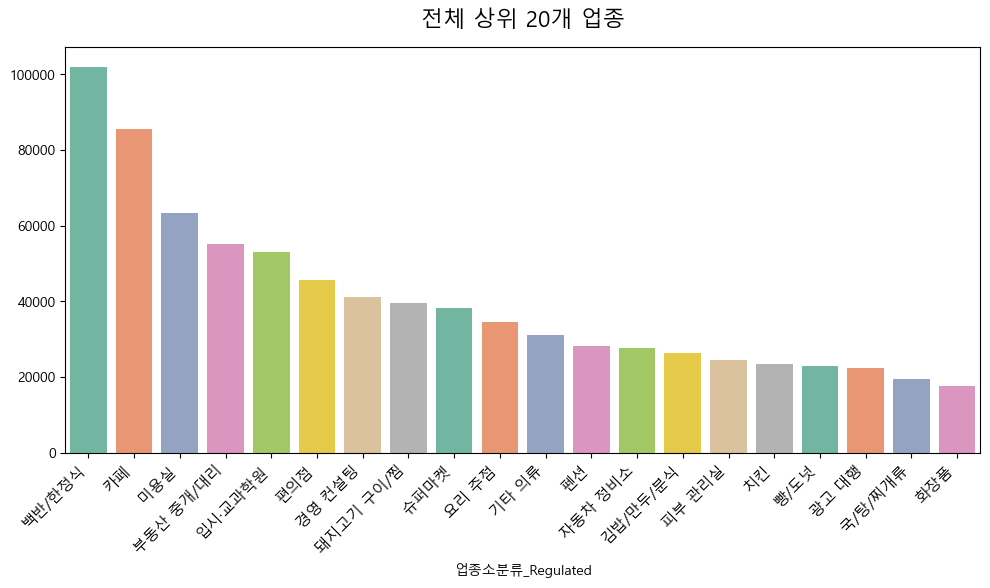

In [56]:
# 전체 상위 20개 업종
plt.figure(figsize=(10, 6))
categories_all = proc_shop_cat_df['업종소분류_Regulated'].value_counts().head(20)
sns.barplot(x=categories_all.index, y=categories_all.values, palette='Set2')
plt.title('전체 상위 20개 업종', fontsize=16, y=1.03)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.tight_layout()
plt.show()

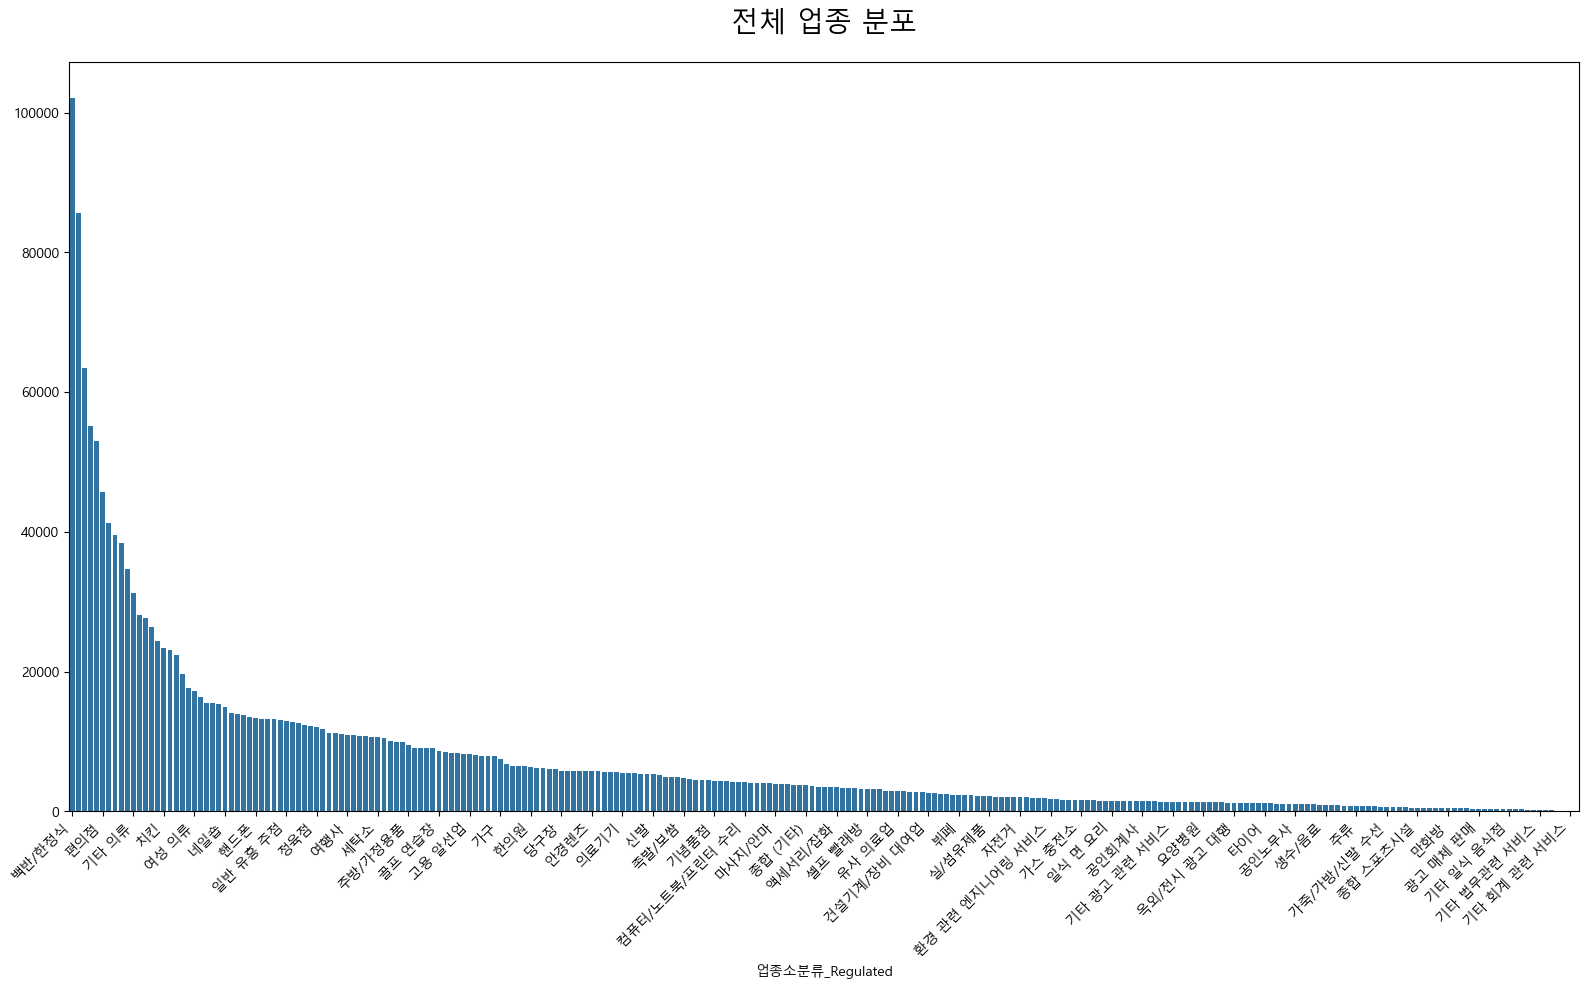

가장 많은 클래스: 백반/한정식 (102085개)
가장 적은 클래스: 분류 안된 외국식 음식점 (29개)
3520.17배 차이


In [49]:
# 전체 업종
step = 5

plt.figure(figsize=(16, 10))
categories_all = proc_shop_cat_df['업종소분류_Regulated'].value_counts()
ax = sns.barplot(x=categories_all.index, y=categories_all.values)
plt.title('전체 업종 분포', fontsize=20, y=1.03)
xticks = [i for i in range(0, len(categories_all.index), step)]
xticklabels = [categories_all.index[i] for i in xticks]
plt.xticks(xticks, labels=xticklabels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 가장 많은 클래스 (최대값)
max_idx = categories_all.values.argmax()
max_class = categories_all.index[max_idx]
max_count = categories_all.values[max_idx]
print(f"가장 많은 클래스: {max_class} ({max_count}개)")

# 가장 적은 클래스 (최소값)
min_idx = categories_all.values.argmin()
min_class = categories_all.index[min_idx]
min_count = categories_all.values[min_idx]
print(f"가장 적은 클래스: {min_class} ({min_count}개)")
print(f"{max_count/min_count:.2f}배 차이")

In [25]:
# 최종 데이터셋
final_df = proc_shop_cat_df[['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']]

In [26]:
# 데이터 저장 디렉토리 생성
output_dir = './processed_data'
os.makedirs(output_dir, exist_ok=True)

# CSV 파일로 저장
output_path = f"{output_dir}/region_all_processed_data.csv"
final_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n통합 데이터가 저장되었습니다: {output_path}")
print(f"최종 데이터 크기: {final_df.shape}")


통합 데이터가 저장되었습니다: ./processed_data/region_all_processed_data.csv
최종 데이터 크기: (1818487, 5)


In [27]:
# 지역별 데이터도 따로 저장
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    region_output = f"{output_dir}/regions/{region}_processed_data.csv"
    region_df.to_csv(region_output, index=False, encoding='utf-8')
    print(f"{region} 데이터 저장 완료: {region_output} (크기: {region_df.shape})")

강원 데이터 저장 완료: ./processed_data/regions/강원_processed_data.csv (크기: (92835, 5))
경기 데이터 저장 완료: ./processed_data/regions/경기_processed_data.csv (크기: (484006, 5))
경남 데이터 저장 완료: ./processed_data/regions/경남_processed_data.csv (크기: (117875, 5))
경북 데이터 저장 완료: ./processed_data/regions/경북_processed_data.csv (크기: (95624, 5))
광주 데이터 저장 완료: ./processed_data/regions/광주_processed_data.csv (크기: (49459, 5))
대구 데이터 저장 완료: ./processed_data/regions/대구_processed_data.csv (크기: (74425, 5))
대전 데이터 저장 완료: ./processed_data/regions/대전_processed_data.csv (크기: (48447, 5))
부산 데이터 저장 완료: ./processed_data/regions/부산_processed_data.csv (크기: (96378, 5))
서울 데이터 저장 완료: ./processed_data/regions/서울_processed_data.csv (크기: (354806, 5))
세종 데이터 저장 완료: ./processed_data/regions/세종_processed_data.csv (크기: (9451, 5))
울산 데이터 저장 완료: ./processed_data/regions/울산_processed_data.csv (크기: (31426, 5))
인천 데이터 저장 완료: ./processed_data/regions/인천_processed_data.csv (크기: (79540, 5))
전남 데이터 저장 완료: ./processed_data/regions/전남_processed_data.csv (

(np.float64(-1.0999999582500812),
 np.float64(1.099999933609888),
 np.float64(-1.306814554476159),
 np.float64(1.1098483223516693))

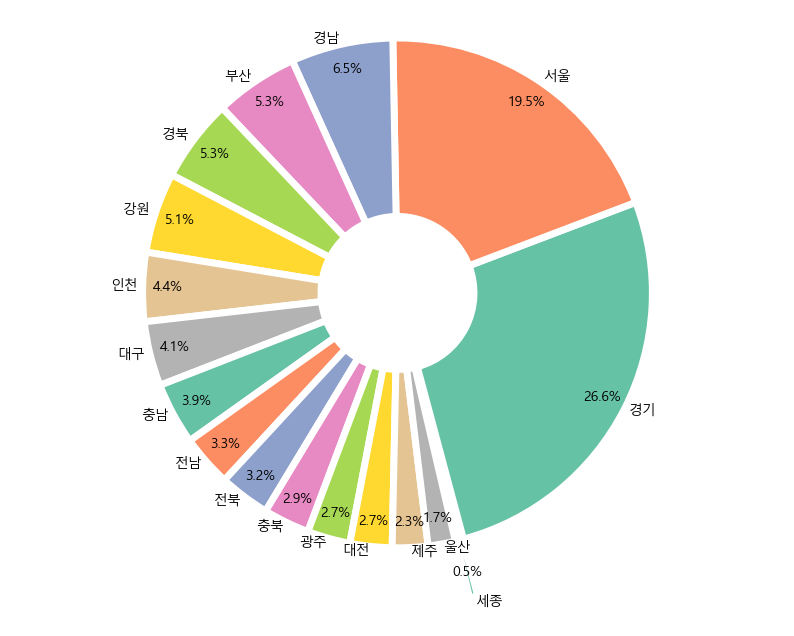

In [28]:
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(10, 8))
plt.pie(region_counts,
        labels=region_counts.index,
        autopct='%1.1f%%',
        startangle=-75,
        wedgeprops=wedgeprops,
        colors=sns.color_palette("Set2", len(region_counts)),
        labeldistance=1.02,
        pctdistance=0.9,
        explode=[0] * (len(region_counts)-1) + [0.23] # 각 조각을 약간 띄움
        )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [29]:
# 전체 데이터 요약
print("\n=== 데이터 통합 및 처리 요약 ===")
print(f"통합 데이터 크기: {region_all_df.shape}")
print(f"중복 처리 후 데이터 크기: {processed_df.shape}")
print(f"제거된 중복 레코드 수: {len(region_all_df) - len(processed_df)}")
print(f"데이터 감소율: {(len(region_all_df) - len(processed_df)) / len(region_all_df):.2%}")
print(f"고유 상호명 수: {final_df['상호명_Regulated'].nunique():,}개")
print(f"고유 업종 수: {final_df['업종소분류_Regulated'].nunique():,}개")

# 지역별 통계
print("\n지역별 통계:")
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    print(f"- {region} 데이터: {len(region_df):,}개 ({len(region_df)/len(processed_df):.1%})")
    print(f"  고유 상호명 수: {region_df['상호명_Regulated'].nunique():,}개")
    print(f"  고유 업종 수: {region_df['업종소분류_Regulated'].nunique():,}개")
    print(f"  가장 많은 업종: {region_df['업종소분류_Regulated'].value_counts().index[0]}")


=== 데이터 통합 및 처리 요약 ===
통합 데이터 크기: (2792839, 5)
중복 처리 후 데이터 크기: (1818487, 5)
제거된 중복 레코드 수: 974352
데이터 감소율: 34.89%
고유 상호명 수: 1,818,487개
고유 업종 수: 247개

지역별 통계:
- 강원 데이터: 92,835개 (5.1%)
  고유 상호명 수: 92,835개
  고유 업종 수: 245개
  가장 많은 업종: 백반/한정식
- 경기 데이터: 484,006개 (26.6%)
  고유 상호명 수: 484,006개
  고유 업종 수: 247개
  가장 많은 업종: 백반/한정식
- 경남 데이터: 117,875개 (6.5%)
  고유 상호명 수: 117,875개
  고유 업종 수: 247개
  가장 많은 업종: 백반/한정식
- 경북 데이터: 95,624개 (5.3%)
  고유 상호명 수: 95,624개
  고유 업종 수: 245개
  가장 많은 업종: 백반/한정식
- 광주 데이터: 49,459개 (2.7%)
  고유 상호명 수: 49,459개
  고유 업종 수: 246개
  가장 많은 업종: 백반/한정식
- 대구 데이터: 74,425개 (4.1%)
  고유 상호명 수: 74,425개
  고유 업종 수: 247개
  가장 많은 업종: 백반/한정식
- 대전 데이터: 48,447개 (2.7%)
  고유 상호명 수: 48,447개
  고유 업종 수: 246개
  가장 많은 업종: 백반/한정식
- 부산 데이터: 96,378개 (5.3%)
  고유 상호명 수: 96,378개
  고유 업종 수: 246개
  가장 많은 업종: 백반/한정식
- 서울 데이터: 354,806개 (19.5%)
  고유 상호명 수: 354,806개
  고유 업종 수: 247개
  가장 많은 업종: 경영 컨설팅
- 세종 데이터: 9,451개 (0.5%)
  고유 상호명 수: 9,451개
  고유 업종 수: 232개
  가장 많은 업종: 카페
- 울산 데이터: 31,426개 (1.7%)
  고유 상호명 수: 31,

In [30]:
# 상호명 길이 분포
final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)

# 길이 통계
print("\n상호명 길이 통계:")
print(final_df[['상호명_Regulated_길이']].describe())


상호명 길이 통계:
       상호명_Regulated_길이
count      1.818487e+06
mean       6.677731e+00
std        2.952799e+00
min        0.000000e+00
25%        5.000000e+00
50%        6.000000e+00
75%        8.000000e+00
max        5.100000e+01


C:\Users\hojin\AppData\Local\Temp\ipykernel_31112\3310702641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)


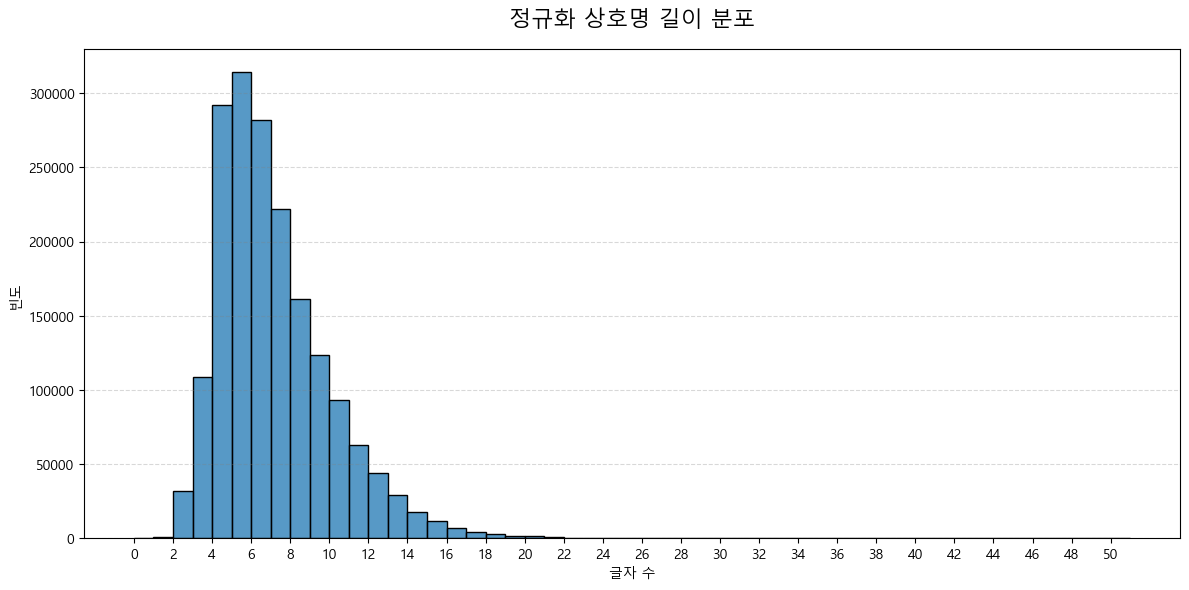

In [51]:
# 상호명 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(final_df['상호명_Regulated_길이'], bins=51)
plt.title('정규화 상호명 길이 분포', fontsize=16, y=1.03)
plt.xlabel('글자 수')
plt.ylabel('빈도')
min_x = int(final_df['상호명_Regulated_길이'].min())
max_x = int(final_df['상호명_Regulated_길이'].max())
plt.xticks(np.arange(min_x, max_x + 1, 2))
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
plt.tight_layout()
plt.show()

C:\Users\hojin\AppData\Local\Temp\ipykernel_31112\491832076.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='업종소분류_Regulated', y='상호명_Regulated_길이', data=filtered_data, order=top_categories, palette='Set2')


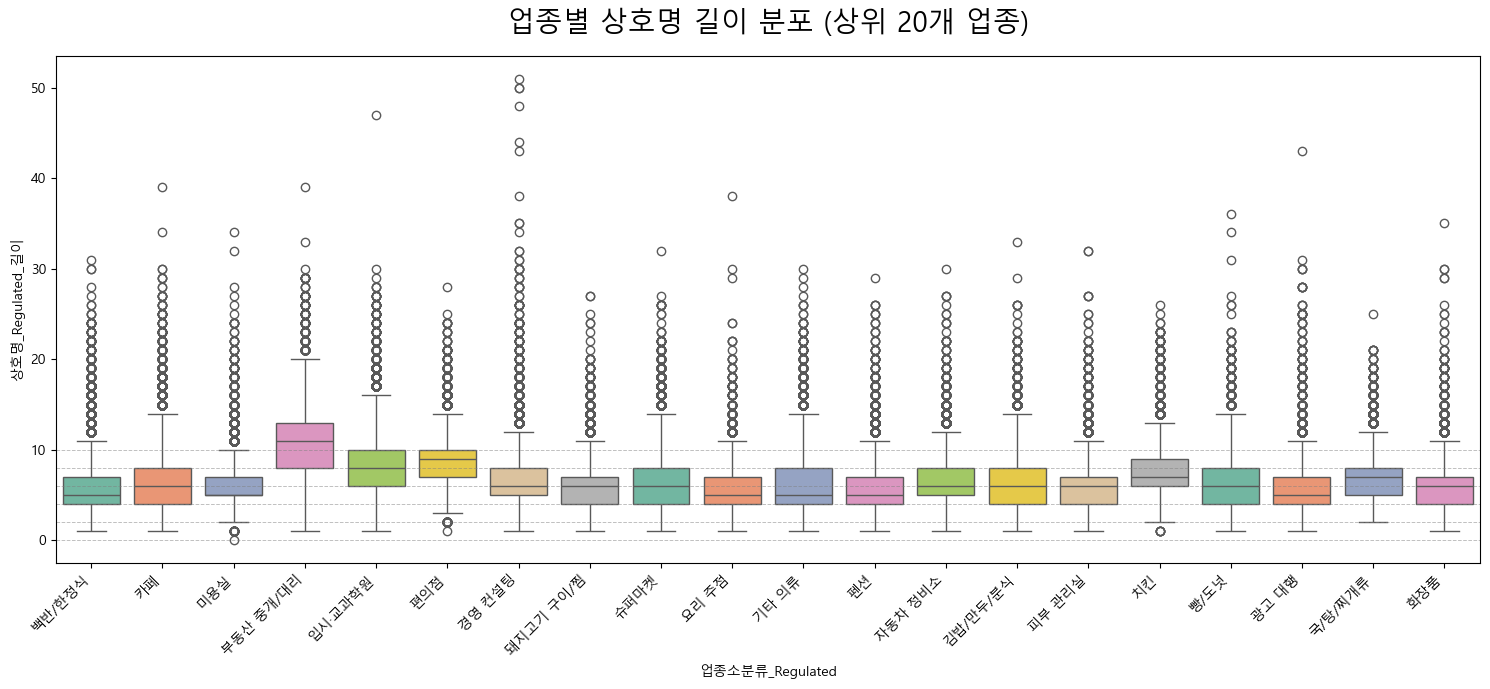

백반/한정식: 102,085개
카페: 85,578개
미용실: 63,431개
부동산 중개/대리: 55,192개
입시·교과학원: 52,962개
편의점: 45,771개
경영 컨설팅: 41,248개
돼지고기 구이/찜: 39,556개
슈퍼마켓: 38,356개
요리 주점: 34,667개
기타 의류: 31,214개
펜션: 28,162개
자동차 정비소: 27,692개
김밥/만두/분식: 26,328개
피부 관리실: 24,440개
치킨: 23,385개
빵/도넛: 23,031개
광고 대행: 22,396개
국/탕/찌개류: 19,641개
화장품: 17,650개


In [52]:
# 업종별 상호명 길이 분석
counts = 20
category_counts = final_df['업종소분류_Regulated'].value_counts()
top_categories = category_counts.head(counts).index.tolist()
plt.figure(figsize=(15, 7))  # 그래프 크기 조금 더 늘림

# 데이터 필터링
filtered_data = final_df[final_df['업종소분류_Regulated'].isin(top_categories)]

# boxplot 생성 
sns.boxplot(x='업종소분류_Regulated', y='상호명_Regulated_길이', data=filtered_data, order=top_categories, palette='Set2')
plt.title(f'업종별 상호명 길이 분포 (상위 {counts}개 업종)', fontsize=20, y=1.03)
plt.xticks(rotation=45, ha='right')
for y in range(0, 11, 2):
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.tight_layout()
plt.show()

# 업종별 데이터 개수 확인 (확인용)
for category in top_categories:
    count = len(filtered_data[filtered_data['업종소분류_Regulated'] == category])
    print(f"{category}: {count:,}개")